# Data Enrichment, Data Normalization and Standardization

## Table of Contents

1. Introduction
2. Examples
3. References and Further Reading


## 1. Introduction


In [1]:
import os
import json
import pandas as pd
from openai import OpenAI
import numpy as np
from dotenv import load_dotenv, find_dotenv
from rich.console import Console

In [2]:
console = Console()

load_dotenv(find_dotenv())
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")
console.print(f"[dark_orange]Using OpenAI API key: {OPENAI_API_KEY[:12]}[/]")
# Set up OpenAI API key
client = OpenAI(api_key=OPENAI_API_KEY)

Using OpenAI API key: sk-proj-LRO5

In [3]:
def get_first_value(dict_variable):
    """The function clean takes a dictionary (dict_variable) as input and returns the value of the first key-value pair in the dictionary.

    Here's a breakdown:

    iter(dict_variable.values()) creates an iterator over the dictionary's values.
    next(...) retrieves the first value from the iterator.
    So, if you have a dictionary like {'a': 1, 'b': 2, 'c': 3}, calling clean on it would return 1, which is the value associated with the first key 'a'.

    Note that this function assumes the dictionary is not empty. If the dictionary is empty, next will raise a StopIteration exception.
    """
    return next(iter(dict_variable.values()))

## 2. Example 1: Analyzing and Classifying News Articles


In [4]:
# Sample news article
news_article = """
[ARTICLE 1]
The stock market saw significant gains today as tech companies reported strong quarterly earnings. 
Apple, Microsoft, and Amazon all beat analyst expectations, driving the NASDAQ to new highs. 
Meanwhile, concerns about inflation have eased slightly following the Federal Reserve's latest statement.

[ARTICLE 2]
Simone Biles fought through pain in her calf on Sunday to post an impressive all-around score and display 
the qualities which have made one of the greatest gymnasts of all time on her return to the Olympics.
"""

# Analyze and classify the article
response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role": "system",
            "content": "You are a helpful assistant that analyzes and classifies news articles.",
        },
        {
            "role": "user",
            "content": f"Analyze this news article and classify it into one of these categories: Technology, Sports, Other. Output in JSON form: {news_article}",
        },
    ],
    response_format={"type": "json_object"},
)

print(response.choices[0].message.content)

{
  "articles": [
    {
      "article": 1,
      "category": "Technology"
    },
    {
      "article": 2,
      "category": "Sports"
    }
  ]
}


This example demonstrates how Gen AI can analyze a news article, classify it into categories, and provide a summary. This is useful for data engineers working with large collections of news articles, helping to organize and extract key information efficiently.


## 2. Example 1: Filling Missing Text Data (Text Data Imputation)


In [5]:
# Sample dataset with missing text data
data = {
    "Title": [
        "The Great Gatsby",
        "To Kill a Mockingbird",
        "1984",
        "Pride and Prejudice",
    ],
    "Author": ["F. Scott Fitzgerald", "Harper Lee", "George Orwell", None],
    "Genre": ["Novel", "Fiction", "Dystopian", "Romance"],
}
df = pd.DataFrame(data)
print("Original DataFrame:")
print(df)

Original DataFrame:
                   Title               Author      Genre
0       The Great Gatsby  F. Scott Fitzgerald      Novel
1  To Kill a Mockingbird           Harper Lee    Fiction
2                   1984        George Orwell  Dystopian
3    Pride and Prejudice                 None    Romance


In [6]:
# Function to predict missing author

for index, row in df.iterrows():
    if row["Author"] is None:
        prompt = "Who is the author of this book? Return only the answer. {}".format(
            row["Title"]
        )

        response = client.chat.completions.create(
            model="gpt-4o-mini", messages=[{"role": "user", "content": prompt}]
        )

        df.at[index, "Author"] = response.choices[0].message.content

print(df)

                   Title               Author      Genre
0       The Great Gatsby  F. Scott Fitzgerald      Novel
1  To Kill a Mockingbird           Harper Lee    Fiction
2                   1984        George Orwell  Dystopian
3    Pride and Prejudice          Jane Austen    Romance


In [7]:
# Sample dataset with missing text data
data = {
    "Book Title": [None, "To Kill a Mockingbird", "1984", "Pride and Prejudice"],
    "Author": ["F. Scott Fitzgerald", "Harper Lee", "George Orwell", None],
    "Genre": ["Novel", "Fiction", "Dystopian", "Romance"],
}
df = pd.DataFrame(data)
print("Original DataFrame:")
print(df)

Original DataFrame:
              Book Title               Author      Genre
0                   None  F. Scott Fitzgerald      Novel
1  To Kill a Mockingbird           Harper Lee    Fiction
2                   1984        George Orwell  Dystopian
3    Pride and Prejudice                 None    Romance


In [8]:
for index, row in df.iterrows():
    for col in df.columns:
        if row[col] is None:
            prompt = "Given this information: {}. What is the {}? Return only the answer".format(
                [
                    {col_loop: row[col_loop]}
                    for col_loop in df.columns
                    if col_loop != col
                ],
                col,
            )
            print(prompt)

            response = client.chat.completions.create(
                model="gpt-4o-mini", messages=[{"role": "user", "content": prompt}]
            )

            df.at[index, col] = response.choices[0].message.content

print(df)

Given this information: [{'Author': 'F. Scott Fitzgerald'}, {'Genre': 'Novel'}]. What is the Book Title? Return only the answer
Given this information: [{'Book Title': 'Pride and Prejudice'}, {'Genre': 'Romance'}]. What is the Author? Return only the answer
              Book Title               Author      Genre
0       The Great Gatsby  F. Scott Fitzgerald      Novel
1  To Kill a Mockingbird           Harper Lee    Fiction
2                   1984        George Orwell  Dystopian
3    Pride and Prejudice          Jane Austen    Romance


<a id='example2'></a>

## 2. Example 2: Filling Missing Numerical Data


In [9]:
# Sample dataset with missing numerical data
data_num = pd.DataFrame(
    {
        "Product": ["A", "B", "C", "D", "E"],
        "Price": [10.99, np.nan, 15.50, 8.75, np.nan],
        "Quantity": [100, 150, np.nan, 200, 175],
    }
)

print("Original dataset:")
print(data_num)

Original dataset:
  Product  Price  Quantity
0       A  10.99     100.0
1       B    NaN     150.0
2       C  15.50       NaN
3       D   8.75     200.0
4       E    NaN     175.0


In [10]:
# Function to fill missing numerical data
def fill_missing_numerical(row):
    if pd.isna(row["Price"]) or pd.isna(row["Quantity"]):
        prompt = f"Predict the missing values for this product: Product: {row['Product']}, Price: {row['Price']}, Quantity: {row['Quantity']}. Consider market trends and product characteristics. Output in JSON form."

        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": prompt}],
            response_format={"type": "json_object"},
        )

        result = json.loads(response.choices[0].message.content)

        if pd.isna(row["Price"]):
            row["Price"] = float(result.get("Price", row["Price"]))
        if pd.isna(row["Quantity"]):
            row["Quantity"] = int(result.get("Quantity", row["Quantity"]))

    return row


# Apply the function to each row
data_num_filled = data_num.apply(fill_missing_numerical, axis=1)

print("Dataset with filled missing values:")
print(data_num_filled)

Dataset with filled missing values:
  Product  Price  Quantity
0       A  10.99     100.0
1       B  29.99     150.0
2       C  15.50     100.0
3       D   8.75     200.0
4       E  29.99     175.0


In [11]:
# Sample dataset with missing numerical data
data_num = pd.DataFrame(
    {
        "Product": ["iPhone 12", "iPhone 11", "iPhone X", "iPhone 7", "iPhone 14"],
        "Price": [599, 499, 399, 299, np.nan],
        "Number of days since release": [1374, 1773, np.nan, 2872, 681],
    }
)

print("Original dataset:")
print(data_num)

Original dataset:
     Product  Price  Number of days since release
0  iPhone 12  599.0                        1374.0
1  iPhone 11  499.0                        1773.0
2   iPhone X  399.0                           NaN
3   iPhone 7  299.0                        2872.0
4  iPhone 14    NaN                         681.0


In [12]:
# Function to fill missing numerical data
def fill_missing_numerical(row):
    if pd.isna(row["Price"]) or pd.isna(row["Number of days since release"]):
        prompt = f"Predict the missing values for this product: Product: {row['Product']}, Price: {row['Price']}, Quantity: {row['Number of days since release']}. Consider market trends and product characteristics. You must provide a value. Only return the value, nothing else"

        response = client.chat.completions.create(
            model="gpt-4o-mini", messages=[{"role": "user", "content": prompt}]
        )

        result = response.choices[0].message.content

        if pd.isna(row["Price"]):
            row["Price"] = result
        if pd.isna(row["Number of days since release"]):
            row["Number of days since release"] = result

    return row


# Apply the function to each row
data_num_filled = data_num.apply(fill_missing_numerical, axis=1)

print("Dataset with filled missing values:")
print(data_num_filled)

Dataset with filled missing values:
     Product   Price Number of days since release
0  iPhone 12   599.0                       1374.0
1  iPhone 11   499.0                       1773.0
2   iPhone X   399.0                         2500
3   iPhone 7   299.0                       2872.0
4  iPhone 14  999.99                        681.0


<a id='example3'></a>

## 2. Example 3: Filling Missing Time Series Data


In [13]:
# Sample time series dataset with missing values
dates = pd.date_range(start="2023-01-01", end="2023-01-10", freq="D")
data_ts = pd.DataFrame(
    {"Date": dates, "Temperature": [20, 22, np.nan, 19, 18, np.nan, 23, 25, 24, np.nan]}
)

print("Original dataset:")
print(data_ts)

Original dataset:
        Date  Temperature
0 2023-01-01         20.0
1 2023-01-02         22.0
2 2023-01-03          NaN
3 2023-01-04         19.0
4 2023-01-05         18.0
5 2023-01-06          NaN
6 2023-01-07         23.0
7 2023-01-08         25.0
8 2023-01-09         24.0
9 2023-01-10          NaN


In [14]:
# Function to fill missing time series data
def fill_missing_timeseries(data):
    context = data.to_json(orient="records", date_format="iso")
    prompt = f"Fill in the missing temperature values in this time series data. Consider trends and patterns. Data: {context}. Output in JSON form."

    print(prompt)

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        response_format={"type": "json_object"},
    )

    result = json.loads(response.choices[0].message.content)
    filled_data = pd.DataFrame(get_first_value(result))
    filled_data["Date"] = pd.to_datetime(filled_data["Date"])

    return filled_data


# Apply the function to the dataset
data_ts_filled = fill_missing_timeseries(data_ts)

print("Dataset with filled missing values:")
print(data_ts_filled)

Fill in the missing temperature values in this time series data. Consider trends and patterns. Data: [{"Date":"2023-01-01T00:00:00.000","Temperature":20.0},{"Date":"2023-01-02T00:00:00.000","Temperature":22.0},{"Date":"2023-01-03T00:00:00.000","Temperature":null},{"Date":"2023-01-04T00:00:00.000","Temperature":19.0},{"Date":"2023-01-05T00:00:00.000","Temperature":18.0},{"Date":"2023-01-06T00:00:00.000","Temperature":null},{"Date":"2023-01-07T00:00:00.000","Temperature":23.0},{"Date":"2023-01-08T00:00:00.000","Temperature":25.0},{"Date":"2023-01-09T00:00:00.000","Temperature":24.0},{"Date":"2023-01-10T00:00:00.000","Temperature":null}]. Output in JSON form.
Dataset with filled missing values:
        Date  Temperature
0 2023-01-01         20.0
1 2023-01-02         22.0
2 2023-01-03         21.0
3 2023-01-04         19.0
4 2023-01-05         18.0
5 2023-01-06         20.5
6 2023-01-07         23.0
7 2023-01-08         25.0
8 2023-01-09         24.0
9 2023-01-10         22.0


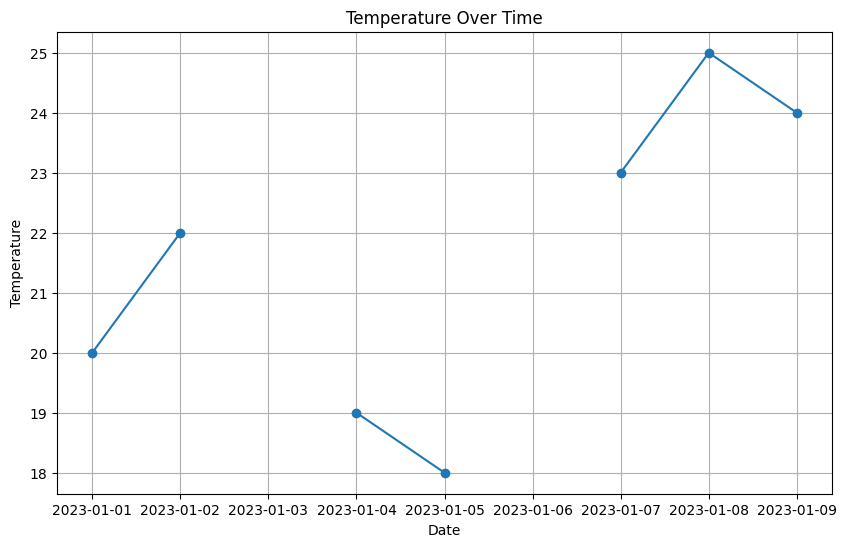

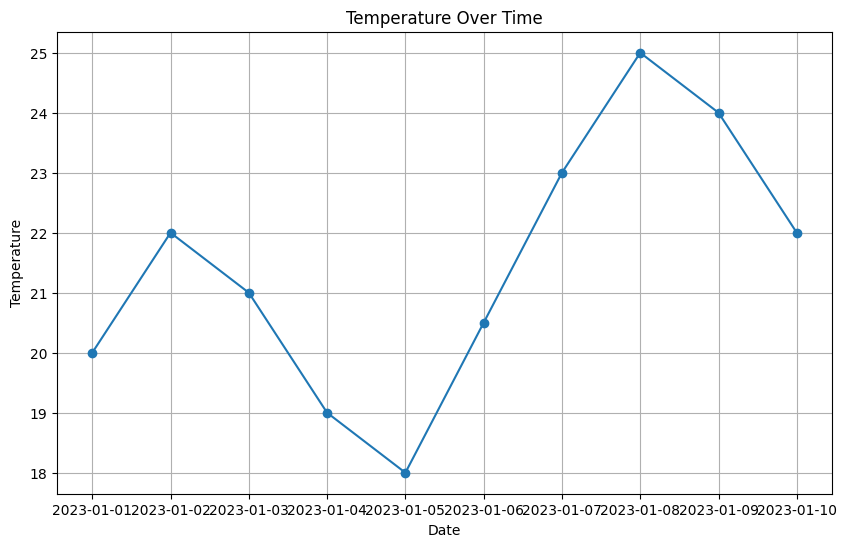

In [15]:
import matplotlib.pyplot as plt

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(data_ts["Date"], data_ts["Temperature"], marker="o")
plt.title("Temperature Over Time")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.grid(True)
plt.show()

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(data_ts_filled["Date"], data_ts_filled["Temperature"], marker="o")
plt.title("Temperature Over Time")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.grid(True)
plt.show()

## 2. Example 4: Converting Data Types


In [16]:
# Sample data with mixed data types
data = {
    "ID": ["001", "002", "003", "00006"],
    "Value": ["10.5", "15", "twenty", "thirty-one"],
    "Date": ["2023-01-01", "01/15/2023", "March 1, 2023", "Dec 4,, '94"],
}
df = pd.DataFrame(data)
print("Original data:")
print(df)

Original data:
      ID       Value           Date
0    001        10.5     2023-01-01
1    002          15     01/15/2023
2    003      twenty  March 1, 2023
3  00006  thirty-one    Dec 4,, '94


In [17]:
# Using Gen AI to convert data types
prompt = f"Convert the following data to appropriate data types. ID should be integer, Value should be float (convert 'twenty' to 20.0), and Date should be in ISO format (YYYY-MM-DD). Output in JSON form:\n{df.to_json()}"

response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": prompt}],
    response_format={"type": "json_object"},
)

converted_data = json.loads(response.choices[0].message.content)
print("\nConverted data:")
print(json.dumps(converted_data, indent=2))


Converted data:
{
  "ID": [
    1,
    2,
    3,
    6
  ],
  "Value": [
    10.5,
    15.0,
    20.0,
    31.0
  ],
  "Date": [
    "2023-01-01",
    "2023-01-15",
    "2023-03-01",
    "1994-12-04"
  ]
}


In [18]:
# Create a new DataFrame with converted values
df_converted = pd.DataFrame(converted_data)
df_converted["ID"] = df_converted["ID"].astype(int)
df_converted["Value"] = df_converted["Value"].astype(float)
df_converted["Date"] = pd.to_datetime(df_converted["Date"])
print("\nFinal converted DataFrame:")
print(df_converted)
print("\nData types:")
print(df_converted.dtypes)


Final converted DataFrame:
   ID  Value       Date
0   1   10.5 2023-01-01
1   2   15.0 2023-01-15
2   3   20.0 2023-03-01
3   6   31.0 1994-12-04

Data types:
ID                int64
Value           float64
Date     datetime64[ns]
dtype: object


In [19]:
addresses = [
    "123 Main St, Apt 4, New York, NY 10001",
    "60601 456 Elm Avenue, Chicago",
    "Los Angeles 789 Oak Rd Suite 100 Cali 90001",
]

prompt = f"Normalize these addresses to a standard format: {addresses}. Output in JSON form with keys: street, city, state, zip."

response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": prompt}],
    response_format={"type": "json_object"},
)

print(response.choices[0].message.content)

{
  "addresses": [
    {
      "street": "123 Main St, Apt 4",
      "city": "New York",
      "state": "NY",
      "zip": "10001"
    },
    {
      "street": "456 Elm Avenue",
      "city": "Chicago",
      "state": "IL",
      "zip": "60601"
    },
    {
      "street": "789 Oak Rd Suite 100",
      "city": "Los Angeles",
      "state": "CA",
      "zip": "90001"
    }
  ]
}


In [20]:
pd.DataFrame(get_first_value(json.loads(response.choices[0].message.content)))

,street,city,state,zip
0,"123 Main St, Apt 4",New York,NY,10001
1,456 Elm Avenue,Chicago,IL,60601
2,789 Oak Rd Suite 100,Los Angeles,CA,90001


<a id='example2'></a>

## 2. Example 5: Normalizing Text Data


In [21]:
# Sample data with inconsistent text formatting
data = {"descriptions": ["RED apple", "Green BANANA", "yellow Lemon", "ORANGE orange"]}
df = pd.DataFrame(data)
print("Original data:")
print(df)

Original data:
    descriptions
0      RED apple
1   Green BANANA
2   yellow Lemon
3  ORANGE orange


In [22]:
# Use Gen AI to normalize text data
prompt = f"Normalize these fruit descriptions by capitalizing only the first letter of each word: {df['descriptions'].tolist()}. Output in JSON form"

response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": prompt}],
    response_format={"type": "json_object"},
)

normalized_descriptions = json.loads(response.choices[0].message.content)
print("Normalized descriptions:")
print(get_first_value(normalized_descriptions))

Normalized descriptions:
['Red Apple', 'Green Banana', 'Yellow Lemon', 'Orange Orange']


In [23]:
# Update the DataFrame with normalized descriptions
df["normalized_descriptions"] = get_first_value(normalized_descriptions)
print("Updated DataFrame:")
print(df)

Updated DataFrame:
    descriptions normalized_descriptions
0      RED apple               Red Apple
1   Green BANANA            Green Banana
2   yellow Lemon            Yellow Lemon
3  ORANGE orange           Orange Orange


<a id='example3'></a>

## 2. Example 6: Standardizing Categorical Data


In [24]:
# Sample data with inconsistent categorical values
data = {
    "categories": [
        "IT",
        "Information Technology",
        "Tech",
        "I.T.",
        "Information Tech",
        "Cyber",
        "Cyberscryity",
        "Cybersecurity",
    ]
}
df = pd.DataFrame(data)
print("Original data:")
print(df)

Original data:
               categories
0                      IT
1  Information Technology
2                    Tech
3                    I.T.
4        Information Tech
5                   Cyber
6            Cyberscryity
7           Cybersecurity


In [25]:
# Use Gen AI to standardize categorical data
prompt = f"Standardize these category names to a single consistent format (either 'IT' or 'Cybersecurity'): {df['categories'].tolist()}. Output in JSON form"

response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": prompt}],
    response_format={"type": "json_object"},
)

standardized_categories = json.loads(response.choices[0].message.content)
print("Standardized categories:")
print(standardized_categories)

Standardized categories:
{'standardized_categories': ['IT', 'IT', 'IT', 'IT', 'IT', 'Cybersecurity', 'Cybersecurity', 'Cybersecurity']}


In [26]:
# Update the DataFrame with standardized categories
df["standardized_categories"] = get_first_value(standardized_categories)
print("Updated DataFrame:")
print(df)

Updated DataFrame:
               categories standardized_categories
0                      IT                      IT
1  Information Technology                      IT
2                    Tech                      IT
3                    I.T.                      IT
4        Information Tech                      IT
5                   Cyber           Cybersecurity
6            Cyberscryity           Cybersecurity
7           Cybersecurity           Cybersecurity


## 2. Example 7: Standardizing


In [27]:
# Sample product names
product_names = [
    "iPhone 12 Pro Max 256GB",
    "Apple iphone 12 pro max (256 gb)",
    "12 Pro Max iPhone - 256GB",
]


# Function to standardize product name
def standardize_product_name(name):
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "system",
                "content": "You are a product name standardization assistant.",
            },
            {
                "role": "user",
                "content": f"Standardize this product name to the format 'Brand Model Storage'. Product name: {name}. Output in JSON form.",
            },
        ],
        response_format={"type": "json_object"},
    )
    return json.loads(response.choices[0].message.content)


# Standardize product names
standardized_names = [standardize_product_name(name) for name in product_names]

# Display results
for original, standardized in zip(product_names, standardized_names):
    print(f"Original: {original}")
    print(f"Standardized: {get_first_value(standardized)}\n")

Original: iPhone 12 Pro Max 256GB
Standardized: Apple iPhone 12 Pro Max 256GB

Original: Apple iphone 12 pro max (256 gb)
Standardized: Apple iPhone 12 Pro Max 256GB

Original: 12 Pro Max iPhone - 256GB
Standardized: Apple iPhone 12 Pro Max 256GB



In [28]:
# Sample customer data
customers = [
    "John Doe, 35 years old, buys electronics frequently",
    "Jane Smith, 28 years old, purchases cosmetics monthly",
    "Bob Johnson, 50 years old, buys gardening supplies occasionally",
]


# Function to categorize customer
def categorize_customer(description):
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "You are a data categorization assistant."},
            {
                "role": "user",
                "content": f"Categorize this customer into one of these categories: Tech Enthusiast, Beauty Lover, Home & Garden. Customer description: {description}. Output in JSON form.",
            },
        ],
        response_format={"type": "json_object"},
    )
    return json.loads(response.choices[0].message.content)


# Categorize customers
categorized_customers = [categorize_customer(customer) for customer in customers]

# Display results
for customer, category in zip(customers, categorized_customers):
    print(f"Customer: {customer}")
    print(f"Category: {category['category']}\n")

Customer: John Doe, 35 years old, buys electronics frequently
Category: Tech Enthusiast

Customer: Jane Smith, 28 years old, purchases cosmetics monthly
Category: Beauty Lover

Customer: Bob Johnson, 50 years old, buys gardening supplies occasionally
Category: Home & Garden



In [29]:
# Sample location data
locations = ["New York, NY", "Los Angeles, California", "Chicago, IL, USA", "San Fran"]


# Function to normalize location data
def normalize_location(location):
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "system",
                "content": "You are a location data normalization assistant.",
            },
            {
                "role": "user",
                "content": f"Normalize this location: {location}. Output in JSON form with city, state, and country.",
            },
        ],
        response_format={"type": "json_object"},
    )
    return json.loads(response.choices[0].message.content)


# Normalize locations
normalized_locations = [normalize_location(loc) for loc in locations]

# Display results
for original, normalized in zip(locations, normalized_locations):
    print(f"Original: {original}")
    print(f"Normalized: {normalized}\n")

Original: New York, NY
Normalized: {'city': 'New York', 'state': 'New York', 'country': 'United States'}

Original: Los Angeles, California
Normalized: {'city': 'Los Angeles', 'state': 'California', 'country': 'United States'}

Original: Chicago, IL, USA
Normalized: {'city': 'Chicago', 'state': 'Illinois', 'country': 'United States'}

Original: San Fran
Normalized: {'city': 'San Francisco', 'state': 'California', 'country': 'United States'}



## 3. References and Further Reading

1. OpenAI API Documentation: https://platform.openai.com/docs/
2. "Natural Language Processing with Transformers" by Lewis Tunstall, Leandro von Werra, and Thomas Wolf
3. "Speech and Language Processing" by Dan Jurafsky and James H. Martin
4. "Text Mining with R" by Julia Silge and David Robinson
5. "Applied Text Analysis with Python" by Benjamin Bengfort, Rebecca Bilbro, and Tony Ojeda
